# MML Tesina - A.Y. 2020/21 - Politecnico di Torino - Hafez Ghaemi - Farzad Imanpour

# 1. Importing required modules, loading the dataset and pre-processing

In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')
import imageio
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import keras
from keras import layers
from sklearn.decomposition import KernelPCA
from os import listdir
from PIL import Image as PImage
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import itertools
import string



In [ ]:
from google.colab import drive
import torch
drive.mount('/content/drive/')
 
if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
 
print(f'Device is set to {DEVICE}')

Mounted at /content/drive/
Device is set to cuda


In [ ]:
def loadImages(dirName, class_mode=None):
    '''
    # This function loads images from any directory
    # :param str dirName: is address of the directory (string)
    # :param str class_mode: is the classification mode (emotion or recognition) (string)
    '''
    assert class_mode in ['emotion', 'recognition'], "Class mode should be either 'emotion' or 'recognition'."
    data = []
    label = []
    imagesList = listdir(dirName)
    for file in imagesList:
        #face = scipy.misc.imread(os.path.join(root, file)) # Load image from a path
        face = imageio.imread(dirName+'/'+file)
        #face = imageio.imread("%s%s" %(dirName, file))
        face = face.reshape(256 * 256, ).tolist()          # Flatten image. Note: size of any image is 256,256
        data.append(face)
        if class_mode == 'recognition':
            label.append(file.split('.')[0])
        if class_mode == 'emotion':
            label.append(file.split('.')[1][:2])
    return np.asarray(data) , label


## Loading data with emotion labels

number of images is 213 and number of features for each image is 65536


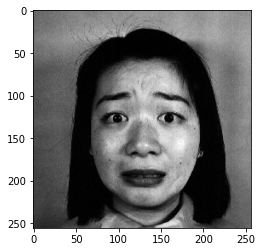

In [ ]:
dirName = '/content/drive/MyDrive/mml/jaffedbase'
#dirName = 'dataset/'
dataset_emo, label_emo = loadImages(dirName, class_mode='emotion')
print("number of images is" , dataset_emo.shape[0] , "and number of features for each image is", dataset_emo.shape[1])

plt.imshow(dataset_emo[0].reshape(256,256) , cmap='gray')
plt.show()

## Loading data with name labels

In [ ]:
dataset_rec, label_rec = loadImages(dirName, class_mode='recognition')
print("number of images is" , dataset_rec.shape[0] , "and number of features for each image is", dataset_rec.shape[1])

number of images is 213 and number of features for each image is 65536


In [ ]:
def z_norm(dataset):
  mean = np.mean(dataset,axis=0)
  std = np.std(dataset, axis=0)
  return (dataset-mean)/std

In [ ]:
dataset_emo_norm = z_norm(dataset_emo)
dataset_rec_norm = z_norm(dataset_rec)

## Image data

In [ ]:
image_data_emo = np.zeros((213,256,256))
for i in range(len(dataset_emo)):
    image_data_emo[i,:,:] = dataset_emo[i].reshape(256,256)

image_data_rec = np.zeros((213,256,256))
for i in range(len(dataset_rec)):
    image_data_rec[i,:,:] = dataset_rec[i].reshape(256,256)
print('Image data:')
print(image_data_rec.shape)

Image data:
(213, 256, 256)


# 2. Normal PCA



In [ ]:
pca_all = PCA()
pca_all.fit(dataset_rec)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print('Number of total PCA components:', pca_all.n_components_)

Number of total PCA components: 213


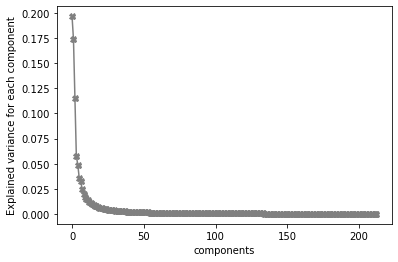

In [ ]:
plt.plot(pca_all.explained_variance_ratio_, marker='X',color="grey")

plt.xlabel('components')
plt.ylabel('Explained variance for each component')
plt.show()




In [ ]:
pca90 = PCA(n_components=0.9)
pca90.fit(dataset_rec)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print('Number of PCA components to preserve 90 percent of explained variance:', pca90.n_components_)

Number of PCA components to preserve 90 percent of explained variance: 44


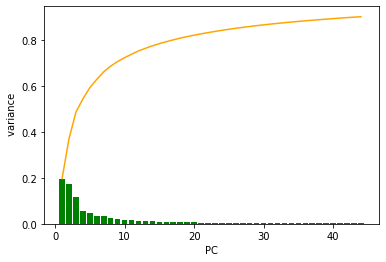

In [ ]:
plt.bar(range(1,len(pca90.explained_variance_ratio_ )+1),pca90.explained_variance_ratio_, color='green')
plt.ylabel(' variance')
plt.xlabel('PC')
plt.plot(range(1,len(pca90.explained_variance_ratio_ )+1),
        np.cumsum(pca90.explained_variance_ratio_),
        c='orange',
        label="Cumulative Explained Variance Ratio")

plt.savefig('explained_variance_ratio_pca90.pdf')

In [ ]:
low_dim = pca90.transform(dataset_rec)
reconstructed90 = pca90.inverse_transform(low_dim)

In [ ]:
low_dim_all = pca_all.transform(dataset_rec)
reconstructed_all = pca_all.inverse_transform(low_dim_all)

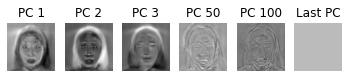

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)

ax1.axis('off')
ax1.imshow(pca_all.components_[0].reshape(256,256),cmap='gray') 
ax1.title.set_text('PC 1')

ax2.axis('off')
ax2.imshow(pca_all.components_[1].reshape(256,256),cmap='gray')
ax2.title.set_text('PC 2')

ax3.axis('off')
ax3.imshow(pca_all.components_[2].reshape(256,256),cmap='gray')
ax3.title.set_text('PC 3')

ax4.axis('off')
ax4.imshow(pca_all.components_[49].reshape(256,256),cmap='gray')
ax4.title.set_text('PC 50')

ax5.axis('off')
ax5.imshow(pca_all.components_[99].reshape(256,256),cmap='gray')
ax5.title.set_text('PC 100')

ax6.axis('off')
ax6.imshow(pca_all.components_[-1].reshape(256,256),cmap='gray')
ax6.title.set_text('Last PC')
plt.savefig('eigenFaces.pdf', bbox_inches='tight')

In [ ]:
def plot_principal_component(dataset, pca, index_image, index_pc):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  original = dataset[index_image].reshape((256,256))
  eigenvector = pca.components_[index_pc].reshape((256,256))
  difference = np.sqrt(np.power(np.subtract(original, eigenvector),2))

  vmax = max(np.max(original), np.max(eigenvector))
  vmin = np.min(difference)

  ax1.axis('off')
  ax1.title.set_text('Original')
  ax1.imshow(original, cmap='gray', vmin=0, vmax=vmax)

  ax2.axis('off')
  ax2.title.set_text('First eigenvector')
  ax2.imshow(eigenvector, cmap='gray')

  ax3.axis('off')
  ax3.title.set_text('Difference')
  ax3.imshow(difference,cmap='hot', vmin = vmin, vmax = vmax)

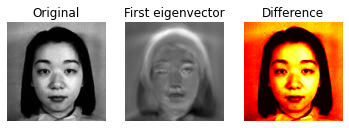

In [ ]:
plot_principal_component(dataset_rec, pca_all, 6,2)
plt.savefig('first_eigenvector_with_diff.pdf')

## Visualizing the two first PCA components

In [ ]:
pca_low = PCA(n_components=2)
pca_low.fit(dataset_rec)
low_dim2 = pca_low.transform(dataset_rec)

### For emotion labels:

In [ ]:
def label_to_int(label):
    label_dis = set(label)
    conv_dict = {}
    counter = 0
    int_labels = []
    for l in list(label_dis):
        conv_dict[l] = counter
        counter += 1
    for l in label:
        int_labels.append(conv_dict[l])
    int_to_label_dict = {value:key for (key,value) in conv_dict.items()}

    return int_labels, conv_dict, int_to_label_dict


In [ ]:
int_label_emo, label_to_int_dict_emo, int_to_label_dict_emo = label_to_int(label_emo)
print("Emotion classes:")
print(label_to_int_dict_emo)

Emotion classes:
{'DI': 0, 'SU': 1, 'FE': 2, 'NE': 3, 'AN': 4, 'HA': 5, 'SA': 6}


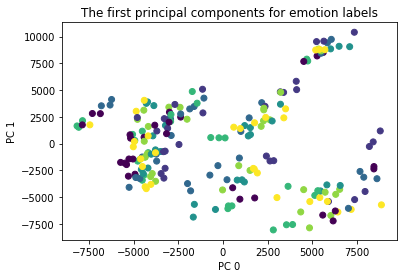

In [ ]:
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.title('The first principal components for emotion labels')
plt.scatter(low_dim2[:,0],low_dim2[:,1],c=int_label_emo)
plt.savefig('pca_2Dimension_emotion.pdf', bbox_inches='tight')

### Name classes

In [ ]:
int_label_rec, label_to_int_dict_rec, int_to_label_dict_rec = label_to_int(label_rec)
print("Person classes:")
print(label_to_int_dict_rec)

Person classes:
{'KL': 0, 'MK': 1, 'TM': 2, 'NA': 3, 'UY': 4, 'KR': 5, 'NM': 6, 'YM': 7, 'KM': 8, 'KA': 9}


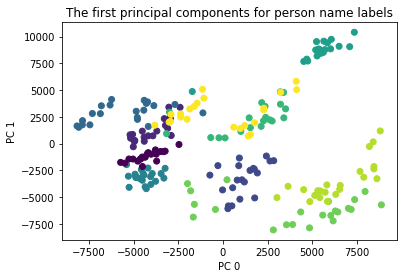

In [ ]:
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.title('The first principal components for person name labels')
plt.scatter(low_dim[:,0],low_dim[:,1],c=int_label_rec)
plt.savefig('pca_2Dimension_recognition.pdf', bbox_inches='tight')

## Inspecting the balance of the dataset

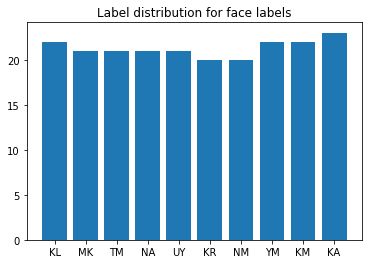

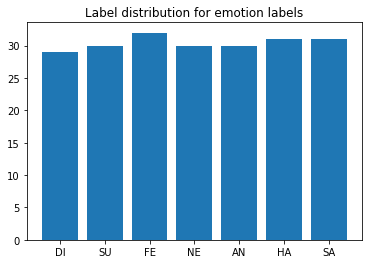

In [ ]:
face_dist = dict(zip(label_to_int_dict_rec.keys(), [0 for i in range(len(label_to_int_dict_rec.keys()))]))
emo_dist = dict(zip(label_to_int_dict_emo.keys(), [0 for i in range(len(label_to_int_dict_emo.keys()))]))
for y in label_rec:
    face_dist[y] += 1
for y in label_emo:
    emo_dist[y] += 1
D = face_dist
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.title('Label distribution for face labels')
plt.show()
print()
D = emo_dist
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.title('Label distribution for emotion labels')
plt.show()

## Reconstructing faces with principal components

In [ ]:
def plot_recon_diff(dataset, index, up_to_pc=213, plot=False):
    pca = PCA(n_components=up_to_pc)
    pca.fit(dataset)
    low_dim = pca.transform(dataset)
    reconstructed = pca.inverse_transform(low_dim)

    original = dataset[index].reshape((256,256))
    pred = reconstructed[index].reshape((256,256))
    difference = np.sqrt(np.power(np.subtract(original, pred),2))
    if plot == True:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        vmax = max(np.max(original), np.max(pred))
        vmin = np.min(difference)

        ax1.axis('off')
        ax1.title.set_text('Original')
        ax1.imshow(original, cmap='gray', vmin=0, vmax=vmax)

        ax2.axis('off')
        ax2.title.set_text('Reconstructed')
        ax2.imshow(pred, cmap='gray', vmin=0, vmax= vmax)

        ax3.axis('off')
        ax3.title.set_text('Difference')
        ax3.imshow(difference,cmap='hot', vmin = vmin, vmax = vmax)
    else:
        return original, pred, difference

### Using different number of PCs:

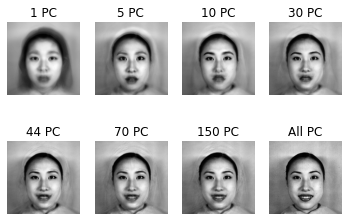

In [ ]:
fig, axes = plt.subplots(2, 4)
index=25
pca1Rec = plot_recon_diff(dataset_rec, index, 1)[1]
pca5Rec = plot_recon_diff(dataset_rec, index, 5)[1]
pca10Rec = plot_recon_diff(dataset_rec, index, 10)[1]
pca25Rec = plot_recon_diff(dataset_rec, index, 25)[1]
pca50Rec = plot_recon_diff(dataset_rec, index, 50)[1]
pca75Rec = plot_recon_diff(dataset_rec, index, 75)[1]
pca100Rec = plot_recon_diff(dataset_rec, index, 100)[1]
pcaFull = plot_recon_diff(dataset_rec, index)[1]

vmax = max(np.max(pca5Rec),np.max(pca1Rec),np.max(pca10Rec),np.max(pca25Rec),np.max(pca50Rec),np.max(pca100Rec),np.max(pca75Rec),np.max(pcaFull))


axes[0][0].axis('off')
axes[0][0].title.set_text('1 PC')
axes[0][0].imshow(pca1Rec, cmap='gray', vmin=0, vmax= vmax)

axes[0][1].axis('off')
axes[0][1].title.set_text('5 PC')
axes[0][1].imshow(pca5Rec, cmap='gray', vmin=0, vmax=vmax)

axes[0][2].axis('off')
axes[0][2].title.set_text('10 PC')
axes[0][2].imshow(pca10Rec, cmap='gray', vmin=0, vmax= vmax)

axes[0][3].axis('off')
axes[0][3].title.set_text('30 PC')
axes[0][3].imshow(pca25Rec, cmap='gray', vmin=0, vmax= vmax)

axes[1][0].axis('off')
axes[1][0].title.set_text('44 PC')
axes[1][0].imshow(pca50Rec, cmap='gray', vmin=0, vmax= vmax)

axes[1][1].axis('off')
axes[1][1].title.set_text('70 PC')
axes[1][1].imshow(pca75Rec, cmap='gray', vmin=0, vmax= vmax)

axes[1][2].axis('off')
axes[1][2].title.set_text('150 PC')
axes[1][2].imshow(pca100Rec, cmap='gray', vmin=0, vmax= vmax)

axes[1][3].axis('off')
axes[1][3].title.set_text('All PC')
axes[1][3].imshow(pcaFull, cmap='gray', vmin=0, vmax= vmax)

plt.savefig('face_reconstructions.pdf', bbox_inches='tight')

### Using components up to 90 percent explained variance:

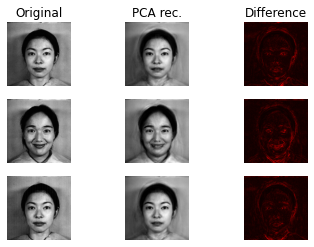

In [ ]:
fig, axes = plt.subplots(3, 3)
totalPlots = axes.shape[0]*axes.shape[1]

for y in range(axes.shape[0]):
    index = np.random.randint(0,100)
    if y==0:
      axes[y][0].title.set_text('Original')
      axes[y][1].title.set_text('PCA rec.')
      axes[y][2].title.set_text('Difference')

    vmax = max(np.max(dataset_rec[index]), np.max(reconstructed90[index]))
  
    axes[y][0].axis('off')
    axes[y][0].imshow(dataset_rec[index].reshape((256,256)), cmap='gray', vmin=0, vmax=vmax)

    axes[y][1].axis('off')
    axes[y][1].imshow(reconstructed90[index].reshape((256,256)), cmap='gray', vmin=0, vmax=vmax)

    axes[y][2].axis('off')
    differenceInReconstruction = np.sqrt(np.power(dataset_rec[index].reshape((256,256))-reconstructed90[index].reshape((256,256)),2))
    vmin = np.min(differenceInReconstruction)
    axes[y][2].imshow(differenceInReconstruction, cmap='hot', vmin=vmin, vmax=vmax)
plt.savefig('face_reconstructions90.pdf', bbox_inches='tight')

# 3. Facial and emotion recognition

# Train-test split (hold-out)

## Emotion labels

In [ ]:
# split into a training and testing set
np.random.seed(2045) # The singularity is near!
X_train_emo, X_test_emo, y_train_emo, y_test_emo = train_test_split(dataset_emo, int_label_emo, test_size=0.2)

## Facial recognition labels

In [ ]:
# split into a training and testing set
np.random.seed(2045) # The singularity is near!
X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(dataset_rec, int_label_rec, test_size=0.2)

## Confusion matrix utility function

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.savefig(title+'.pdf', bbox_inches='tight')
    plt.show()

## Classifier utility function

In [ ]:
def clf_kfold(dataset, labels, clf_tmp, k=20):
    kf = KFold(n_splits=k, shuffle=True)
    local_dataset = dataset
    clf = copy.deepcopy(clf_tmp)
    predictions = np.zeros(k)
    accs = []
    count=0
    time_start = time.time()
    for train_index, test_index in kf.split(local_dataset):
        count+=1
        X_train, X_test = local_dataset[train_index], local_dataset[test_index]
        y_train, y_test = np.array(labels)[train_index], np.array(labels)[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accs.append(accuracy_score(y_pred, y_test))

    time_elapsed = (time.time() - time_start)
    print('Average Accuracy:', np.mean(accs))
    return np.mean(accs), time_elapsed


def clf_kfold_pca(dataset, labels, clf_tmp, k=20):
    all_times = []
    all_accs = []
    for i in range(213):
        pca = PCA(n_components=i+1)
        local_dataset = pca.fit_transform(dataset)
        kf = KFold(n_splits=k, shuffle=True)
        clf = copy.deepcopy(clf_tmp)
        accs = []
        time_start = time.time()
        for train_index, test_index in kf.split(local_dataset):
            X_train, X_test = local_dataset[train_index], local_dataset[test_index]
            y_train, y_test = np.array(labels)[train_index], np.array(labels)[test_index]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accs.append(accuracy_score(y_pred, y_test))

        time_elapsed = (time.time() - time_start)
        print(f'Average Accuracy for {i+1} PCs:', np.mean(accs))
        all_accs.append(np.mean(accs))
        all_times.append(time_elapsed)

    best_pcs = 1+np.argmax(np.array(all_accs))
    print(f'Best number of principal components {best_pcs}')
    pca = PCA(n_components=best_pcs)
    local_dataset = pca.fit_transform(dataset)
    kf = KFold(n_splits=k, shuffle=True)
    clf = copy.deepcopy(clf_tmp)
    # split into a training and testing set
    np.random.seed(2045) # The singularity is near!
    X_train, X_test, y_train, y_test = train_test_split(local_dataset, labels, test_size=0.2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return all_accs, all_times, cm, y_test, y_pred

### Hard SVM (C=1) emotion detection without PCA (K-fold, k=20)

In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_emo, int_label_emo, SVC(C=1))
print('Training time:', time_elapsed)

Average Accuracy: 0.3213636363636364
Training time: 130.15990614891052


### Soft SVM (C=1000) emotion detection without PCA (K-fold, k=20)

In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_emo, int_label_emo, SVC(C=1000))  
print('Training time:', time_elapsed)

Average Accuracy: 0.9159090909090908
Training time: 131.8235113620758


### Hard SVM facial recognition without PCA (k-fold with k=20)

In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_rec, int_label_rec, SVC(C=1))
print('Training time:', time_elapsed)

Average Accuracy: 0.990909090909091
Training time: 95.88530921936035


### Soft SVM (C=1000) facial recognition without PCA (k-fold with k=20)


In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_rec, int_label_rec, SVC(C=1000))
print('Training time:', time_elapsed)

Average Accuracy: 0.9954545454545455
Training time: 97.5131459236145


### Kernel Soft SVM (C=1000) emotion detection without PCA (k-fold with k=20)


In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_emo, int_label_emo, SVC(kernel='rbf',C=1000),)
print('Training time:', time_elapsed)

Average Accuracy: 0.9277272727272727
Training time: 132.75754809379578


### Kernel Soft SVM (C=1000) facial recognition without PCA (k-fold with k=20)


In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_rec, int_label_rec, SVC(C=1000,kernel='rbf'))
print('Training time:', time_elapsed)

Average Accuracy: 0.9954545454545455
Training time: 95.92905330657959


### Hard SVM emotion detection with PCA (k-fold with k=20)


Average Accuracy for 1 PCs: 0.14545454545454548
Average Accuracy for 2 PCs: 0.15818181818181817
Average Accuracy for 3 PCs: 0.16818181818181815
Average Accuracy for 4 PCs: 0.17681818181818185
Average Accuracy for 5 PCs: 0.16863636363636364
Average Accuracy for 6 PCs: 0.16545454545454544
Average Accuracy for 7 PCs: 0.18500000000000003
Average Accuracy for 8 PCs: 0.1931818181818182
Average Accuracy for 9 PCs: 0.17272727272727273
Average Accuracy for 10 PCs: 0.16272727272727275
Average Accuracy for 11 PCs: 0.19136363636363637
Average Accuracy for 12 PCs: 0.2254545454545454
Average Accuracy for 13 PCs: 0.24
Average Accuracy for 14 PCs: 0.24727272727272726
Average Accuracy for 15 PCs: 0.23227272727272727
Average Accuracy for 16 PCs: 0.27136363636363636
Average Accuracy for 17 PCs: 0.27590909090909094
Average Accuracy for 18 PCs: 0.3163636363636363
Average Accuracy for 19 PCs: 0.3368181818181818
Average Accuracy for 20 PCs: 0.35136363636363643
Average Accuracy for 21 PCs: 0.3563636363636363


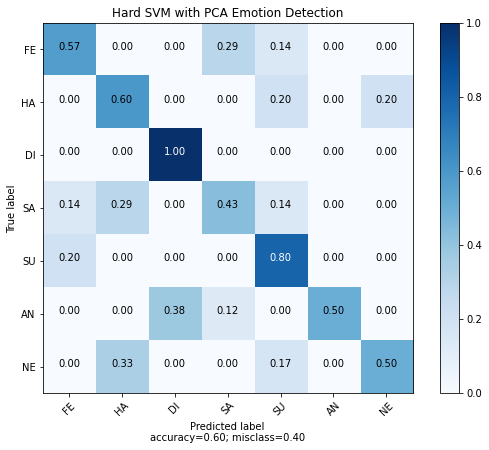

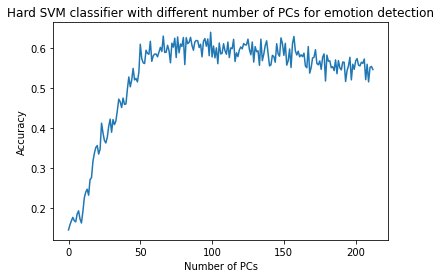

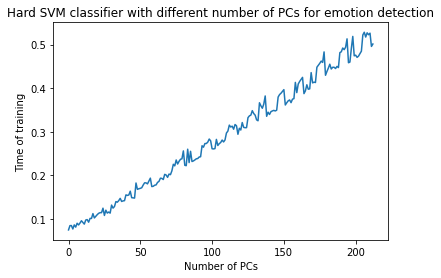

In [ ]:
all_accs_hard_svm, all_times_hard_svm, conf_mat_hard_svm, _, _ = clf_kfold_pca(dataset_emo, int_label_emo, SVC(C=1))
plot_confusion_matrix(conf_mat_hard_svm, label_to_int_dict_emo.keys(), title='Hard SVM with PCA Emotion Detection')
plt.plot(all_accs_hard_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Hard SVM classifier with different number of PCs for emotion detection')
plt.savefig('hard_svm_pca_classifications_accuracy_emo.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_hard_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('Hard SVM classifier with different number of PCs for emotion detection')
plt.savefig('hard_svm_pca_classifications_time_emo.pdf', bbox_inches='tight')
plt.show()

### Soft SVM emotion detection with PCA (k-fold with k=20, C=1000)


Average Accuracy for 1 PCs: 0.20636363636363636
Average Accuracy for 2 PCs: 0.37863636363636366
Average Accuracy for 3 PCs: 0.4945454545454545
Average Accuracy for 4 PCs: 0.5427272727272727
Average Accuracy for 5 PCs: 0.5763636363636364
Average Accuracy for 6 PCs: 0.6527272727272727
Average Accuracy for 7 PCs: 0.7104545454545454
Average Accuracy for 8 PCs: 0.7140909090909091
Average Accuracy for 9 PCs: 0.7604545454545455
Average Accuracy for 10 PCs: 0.8018181818181818
Average Accuracy for 11 PCs: 0.7913636363636364
Average Accuracy for 12 PCs: 0.7940909090909092
Average Accuracy for 13 PCs: 0.7804545454545455
Average Accuracy for 14 PCs: 0.8359090909090909
Average Accuracy for 15 PCs: 0.8277272727272728
Average Accuracy for 16 PCs: 0.840909090909091
Average Accuracy for 17 PCs: 0.8313636363636363
Average Accuracy for 18 PCs: 0.8877272727272727
Average Accuracy for 19 PCs: 0.8690909090909091
Average Accuracy for 20 PCs: 0.8768181818181817
Average Accuracy for 21 PCs: 0.8968181818181817


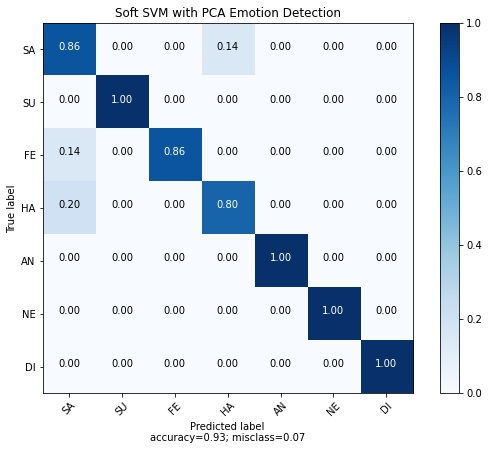

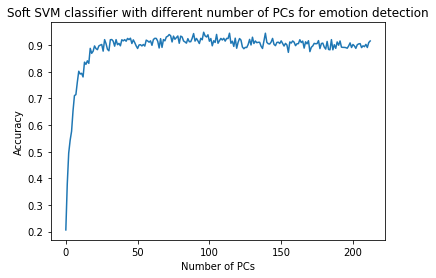

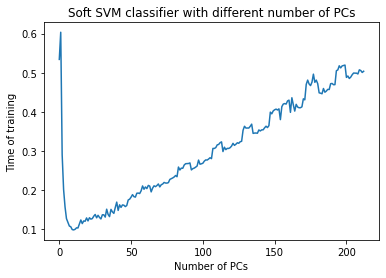

In [ ]:
all_accs_soft_svm, all_times_soft_svm, conf_mat_soft_svm, y_test_emo, y_pred_emo = clf_kfold_pca(dataset_emo, int_label_emo, SVC(C=1000))
plot_confusion_matrix(conf_mat_soft_svm, label_to_int_dict_emo.keys(), title='Soft SVM with PCA Emotion Detection')
plt.plot(all_accs_soft_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Soft SVM classifier with different number of PCs for emotion detection')
plt.savefig('soft_svm_pca_classifications_accuracy_emo.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_soft_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('Soft SVM classifier with different number of PCs')
plt.savefig('soft_svm_pca_classifications_time_emo.pdf', bbox_inches='tight')
plt.show()

### Kernel soft SVM emotion detection with PCA (k-fold with k=20, C=1000)

Average Accuracy for 1 PCs: 0.20636363636363636
Average Accuracy for 2 PCs: 0.3559090909090909
Average Accuracy for 3 PCs: 0.5086363636363636
Average Accuracy for 4 PCs: 0.5440909090909091
Average Accuracy for 5 PCs: 0.5668181818181818
Average Accuracy for 6 PCs: 0.6613636363636364
Average Accuracy for 7 PCs: 0.7104545454545454
Average Accuracy for 8 PCs: 0.7054545454545453
Average Accuracy for 9 PCs: 0.77
Average Accuracy for 10 PCs: 0.8022727272727271
Average Accuracy for 11 PCs: 0.7909090909090909
Average Accuracy for 12 PCs: 0.7936363636363637
Average Accuracy for 13 PCs: 0.7709090909090911
Average Accuracy for 14 PCs: 0.8309090909090908
Average Accuracy for 15 PCs: 0.8281818181818181
Average Accuracy for 16 PCs: 0.85
Average Accuracy for 17 PCs: 0.840909090909091
Average Accuracy for 18 PCs: 0.8831818181818182
Average Accuracy for 19 PCs: 0.8786363636363635
Average Accuracy for 20 PCs: 0.8854545454545454
Average Accuracy for 21 PCs: 0.8963636363636363
Average Accuracy for 22 PCs: 

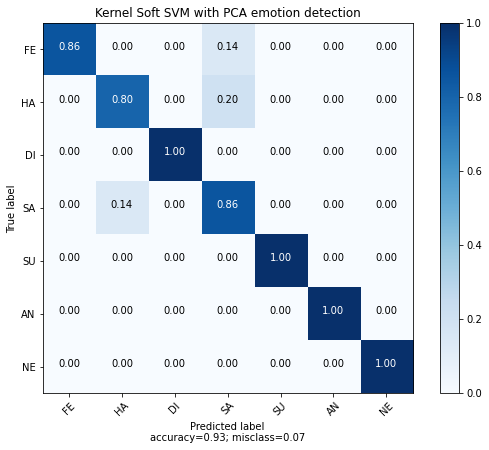

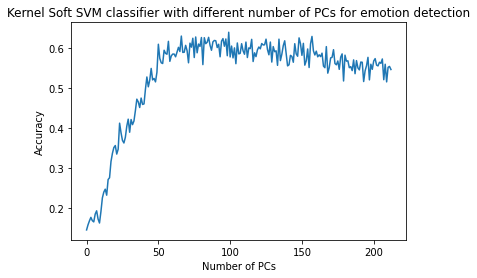

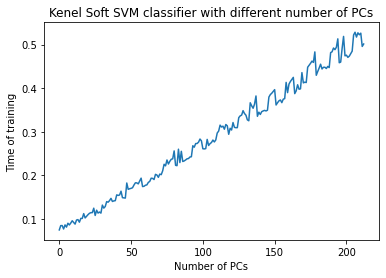

In [ ]:
all_accs_kernel_svm, all_times_kernel_svm, conf_mat_kernel_svm, _, _ = clf_kfold_pca(dataset_emo, int_label_emo, SVC(kernel='rbf',C=1000))
plot_confusion_matrix(conf_mat_kernel_svm, label_to_int_dict_emo.keys(), title='Kernel Soft SVM with PCA emotion detection')
plt.plot(all_accs_hard_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Kernel Soft SVM classifier with different number of PCs for emotion detection')
plt.savefig('kernel_soft_svm_pca_classifications_accuracy_emo.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_hard_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('Kenel Soft SVM classifier with different number of PCs')
plt.savefig('kernel_soft_svm_pca_classifications_time_emo.pdf', bbox_inches='tight')
plt.show()

### Hard SVM facial recognition with PCA (k-fold with k=20)


Average Accuracy for 1 PCs: 0.3995454545454545
Average Accuracy for 2 PCs: 0.8281818181818184
Average Accuracy for 3 PCs: 0.8281818181818181
Average Accuracy for 4 PCs: 0.9295454545454545
Average Accuracy for 5 PCs: 0.9531818181818181
Average Accuracy for 6 PCs: 0.9440909090909091
Average Accuracy for 7 PCs: 0.9768181818181818
Average Accuracy for 8 PCs: 0.9759090909090908
Average Accuracy for 9 PCs: 0.9854545454545454
Average Accuracy for 10 PCs: 0.9772727272727273
Average Accuracy for 11 PCs: 0.9954545454545455
Average Accuracy for 12 PCs: 0.9954545454545455
Average Accuracy for 13 PCs: 0.9954545454545455
Average Accuracy for 14 PCs: 0.9954545454545455
Average Accuracy for 15 PCs: 0.9954545454545455
Average Accuracy for 16 PCs: 0.9954545454545455
Average Accuracy for 17 PCs: 0.9954545454545455
Average Accuracy for 18 PCs: 0.9949999999999999
Average Accuracy for 19 PCs: 0.9949999999999999
Average Accuracy for 20 PCs: 0.9954545454545455
Average Accuracy for 21 PCs: 0.9904545454545455
A

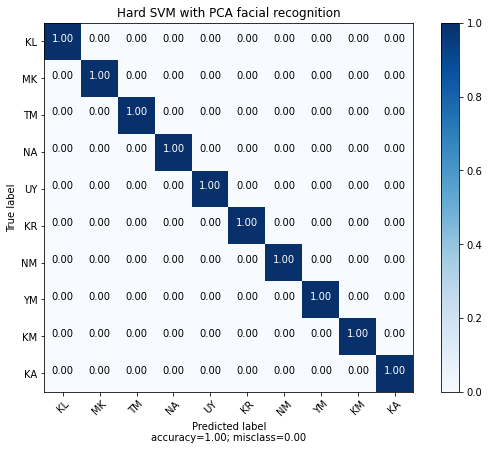

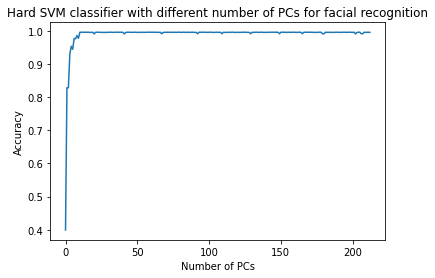

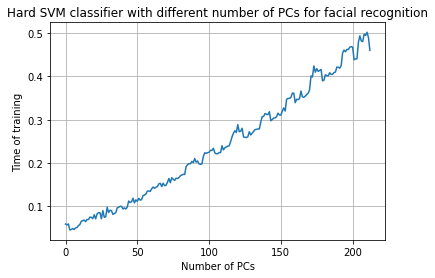

In [ ]:
all_accs_hard_svm, all_times_hard_svm, conf_mat_hard_svm, _, _ = clf_kfold_pca(dataset_rec, int_label_rec, SVC(C=1))
plot_confusion_matrix(conf_mat_hard_svm, label_to_int_dict_rec.keys(), title='Hard SVM with PCA facial recognition')
plt.plot(all_accs_hard_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Hard SVM classifier with different number of PCs for facial recognition')
plt.savefig('hard_svm_pca_classifications_accuracy_rec.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_hard_svm)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('Hard SVM classifier with different number of PCs for facial recognition')
plt.savefig('hard_svm_pca_classifications_time_rec.pdf', bbox_inches='tight')
plt.show()

### Soft SVM facial recognition with PCA (k-fold with k=20, C=1000)


Average Accuracy for 1 PCs: 0.38636363636363635
Average Accuracy for 2 PCs: 0.835
Average Accuracy for 3 PCs: 0.8890909090909093
Average Accuracy for 4 PCs: 0.947272727272727
Average Accuracy for 5 PCs: 0.9618181818181817
Average Accuracy for 6 PCs: 0.9763636363636362
Average Accuracy for 7 PCs: 0.9804545454545455
Average Accuracy for 8 PCs: 0.9863636363636363
Average Accuracy for 9 PCs: 0.9904545454545455
Average Accuracy for 10 PCs: 0.9904545454545455
Average Accuracy for 11 PCs: 0.9904545454545455
Average Accuracy for 12 PCs: 0.9954545454545455
Average Accuracy for 13 PCs: 0.990909090909091
Average Accuracy for 14 PCs: 0.9954545454545455
Average Accuracy for 15 PCs: 0.9954545454545455
Average Accuracy for 16 PCs: 0.9954545454545455
Average Accuracy for 17 PCs: 0.9954545454545455
Average Accuracy for 18 PCs: 0.9954545454545455
Average Accuracy for 19 PCs: 0.9954545454545455
Average Accuracy for 20 PCs: 0.9954545454545455
Average Accuracy for 21 PCs: 0.9904545454545455
Average Accurac

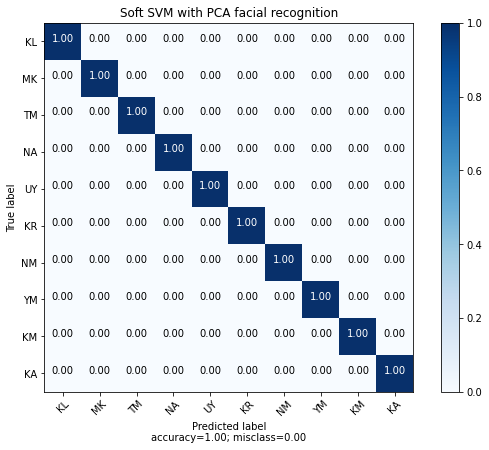

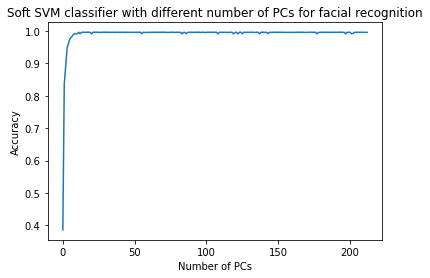

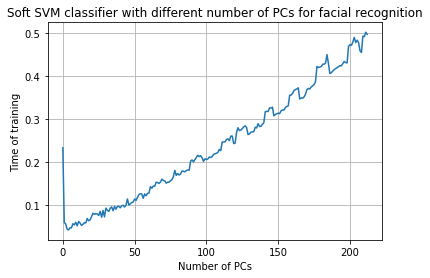

In [ ]:
all_accs_hard_svm, all_times_hard_svm, conf_mat_hard_svm, y_test_rec, y_pred_rec = clf_kfold_pca(dataset_rec, int_label_rec, SVC(C=1000))
plot_confusion_matrix(conf_mat_hard_svm, label_to_int_dict_rec.keys(), title='Soft SVM with PCA facial recognition')
plt.plot(all_accs_hard_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Soft SVM classifier with different number of PCs for facial recognition')
plt.savefig('soft_svm_pca_classifications_accuracy_rec.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_hard_svm)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('Soft SVM classifier with different number of PCs for facial recognition')
plt.savefig('soft_svm_pca_classifications_time_rec.pdf', bbox_inches='tight')
plt.show()

### Kernel soft SVM facial recognition with PCA (k-fold with k=20, C=1000)

Average Accuracy for 1 PCs: 0.38636363636363635
Average Accuracy for 2 PCs: 0.835
Average Accuracy for 3 PCs: 0.8890909090909093
Average Accuracy for 4 PCs: 0.947272727272727
Average Accuracy for 5 PCs: 0.9618181818181817
Average Accuracy for 6 PCs: 0.9763636363636362
Average Accuracy for 7 PCs: 0.9804545454545455
Average Accuracy for 8 PCs: 0.9863636363636363
Average Accuracy for 9 PCs: 0.9904545454545455
Average Accuracy for 10 PCs: 0.9904545454545455
Average Accuracy for 11 PCs: 0.9904545454545455
Average Accuracy for 12 PCs: 0.9954545454545455
Average Accuracy for 13 PCs: 0.990909090909091
Average Accuracy for 14 PCs: 0.9954545454545455
Average Accuracy for 15 PCs: 0.9954545454545455
Average Accuracy for 16 PCs: 0.9954545454545455
Average Accuracy for 17 PCs: 0.9954545454545455
Average Accuracy for 18 PCs: 0.9954545454545455
Average Accuracy for 19 PCs: 0.9954545454545455
Average Accuracy for 20 PCs: 0.9954545454545455
Average Accuracy for 21 PCs: 0.9904545454545455
Average Accurac

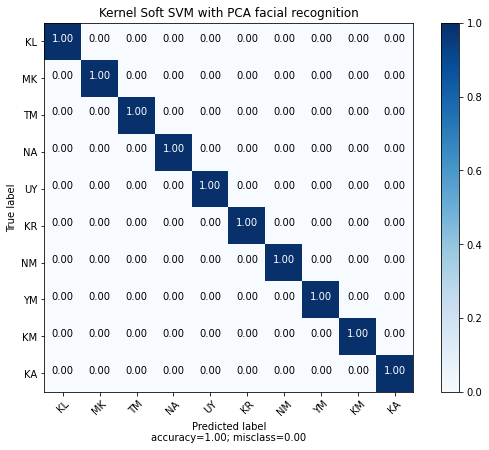

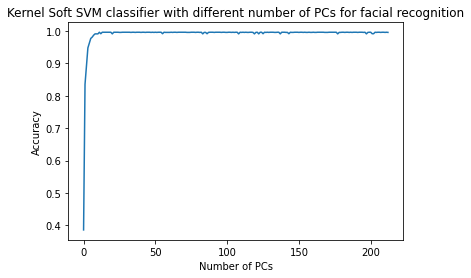

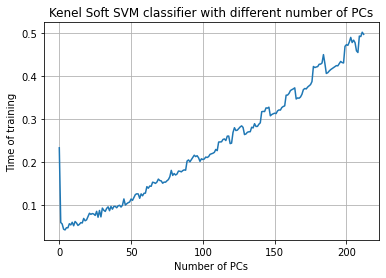

In [ ]:
all_accs_kernel_svm, all_times_kernel_svm, conf_mat_kernel_svm, _, _ = clf_kfold_pca(dataset_rec, int_label_rec, SVC(kernel='rbf',C=1000))
plot_confusion_matrix(conf_mat_kernel_svm, label_to_int_dict_rec.keys(), title='Kernel Soft SVM with PCA facial recognition')
plt.plot(all_accs_hard_svm)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Kernel Soft SVM classifier with different number of PCs for facial recognition')
plt.savefig('kernel_soft_svm_pca_classifications_accuracy_rec.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_hard_svm)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('Kenel Soft SVM classifier with different number of PCs')
plt.savefig('kernel_soft_svm_pca_classifications_time_rec.pdf', bbox_inches='tight')
plt.show()

### LDA without PCA emotion detection

In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_emo, int_label_emo, LDA())
print('Training time:', time_elapsed)

Average Accuracy: 0.7795454545454545
Training time: 71.08015036582947


### LDA with PCA emotion detection

Average Accuracy for 1 PCs: 0.14
Average Accuracy for 2 PCs: 0.13181818181818183
Average Accuracy for 3 PCs: 0.17681818181818182
Average Accuracy for 4 PCs: 0.17681818181818185
Average Accuracy for 5 PCs: 0.2018181818181818
Average Accuracy for 6 PCs: 0.17863636363636365
Average Accuracy for 7 PCs: 0.16772727272727275
Average Accuracy for 8 PCs: 0.18363636363636365
Average Accuracy for 9 PCs: 0.16363636363636364
Average Accuracy for 10 PCs: 0.1890909090909091
Average Accuracy for 11 PCs: 0.21181818181818182
Average Accuracy for 12 PCs: 0.2304545454545454
Average Accuracy for 13 PCs: 0.28590909090909084
Average Accuracy for 14 PCs: 0.37272727272727274
Average Accuracy for 15 PCs: 0.3522727272727273
Average Accuracy for 16 PCs: 0.4177272727272728
Average Accuracy for 17 PCs: 0.5013636363636363
Average Accuracy for 18 PCs: 0.5331818181818182
Average Accuracy for 19 PCs: 0.5813636363636363
Average Accuracy for 20 PCs: 0.5968181818181818
Average Accuracy for 21 PCs: 0.6054545454545454
Avera

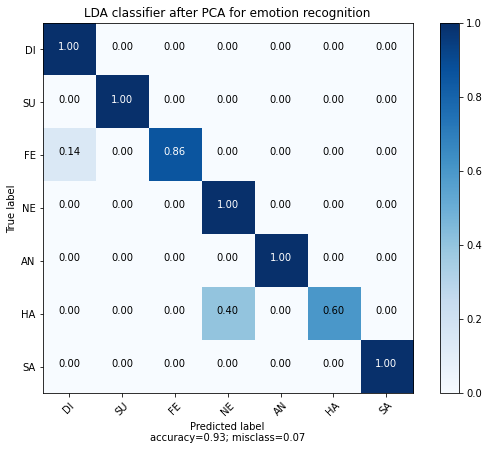

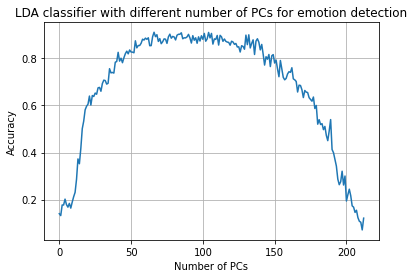

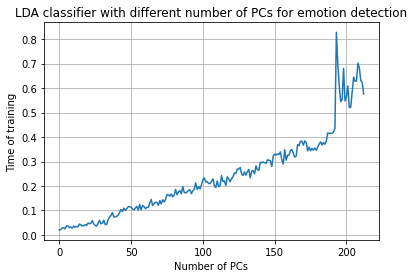

In [ ]:
all_accs_lda, all_times_lda, conf_mat_lda, _, _ = clf_kfold_pca(dataset_emo, int_label_emo, LDA())
plot_confusion_matrix(conf_mat_lda, label_to_int_dict_emo.keys(), 'LDA classifier after PCA for emotion recognition')
plt.plot(all_accs_lda)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('LDA classifier with different number of PCs for emotion detection')
plt.savefig('lda_classifications_accuracy_emo.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_lda)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('LDA classifier with different number of PCs for emotion detection')
plt.savefig('lda_pca_classifications_time_emo.pdf', bbox_inches='tight')
plt.show()

### LDA without PCA facial recognition 

In [ ]:
clf_kfold(dataset_rec, int_label_rec, LDA())
print('Training time:', time_elapsed)

Average Accuracy: 1.0
Training time: 71.08015036582947


### LDA with PCA facial recognition

Average Accuracy for 1 PCs: 0.27681818181818174
Average Accuracy for 2 PCs: 0.7849999999999999
Average Accuracy for 3 PCs: 0.8231818181818182
Average Accuracy for 4 PCs: 0.9200000000000002
Average Accuracy for 5 PCs: 0.9204545454545453
Average Accuracy for 6 PCs: 0.948181818181818
Average Accuracy for 7 PCs: 0.9522727272727272
Average Accuracy for 8 PCs: 0.9477272727272726
Average Accuracy for 9 PCs: 0.9768181818181818
Average Accuracy for 10 PCs: 0.9809090909090908
Average Accuracy for 11 PCs: 0.9954545454545455
Average Accuracy for 12 PCs: 0.985909090909091
Average Accuracy for 13 PCs: 0.9954545454545455
Average Accuracy for 14 PCs: 0.990909090909091
Average Accuracy for 15 PCs: 1.0
Average Accuracy for 16 PCs: 1.0
Average Accuracy for 17 PCs: 1.0
Average Accuracy for 18 PCs: 1.0
Average Accuracy for 19 PCs: 1.0
Average Accuracy for 20 PCs: 1.0
Average Accuracy for 21 PCs: 1.0
Average Accuracy for 22 PCs: 1.0
Average Accuracy for 23 PCs: 1.0
Average Accuracy for 24 PCs: 1.0
Average A

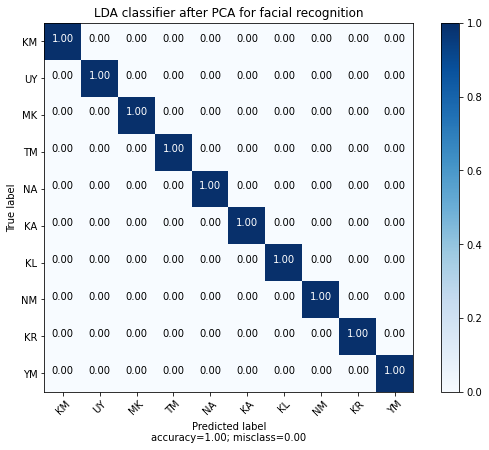

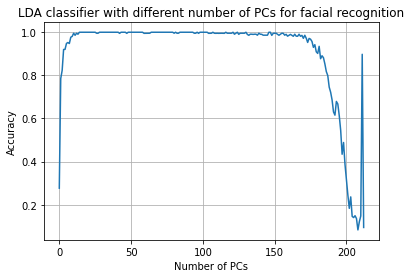

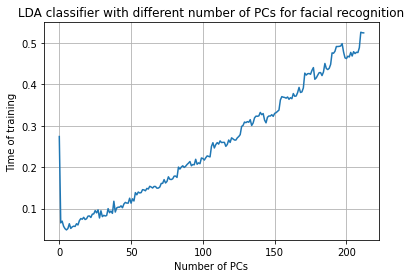

In [ ]:
all_accs_lda, all_times_lda, conf_mat_lda, y_test_rec, y_pred_rec = clf_kfold_pca(dataset_rec, int_label_rec, LDA())
plot_confusion_matrix(conf_mat_lda, label_to_int_dict_rec.keys(), 'LDA classifier after PCA for facial recognition')
plt.plot(all_accs_lda)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('LDA classifier with different number of PCs for facial recognition')
plt.savefig('lda_pca_classifications_accuracy_rec.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_hard_svm)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('LDA classifier with different number of PCs for facial recognition')
plt.savefig('lda_pca_classifications_time_rec.pdf', bbox_inches='tight')
plt.show()

### QDA without PCA emotion detection

In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_emo, int_label_emo, QDA())
print('Training time:', time_elapsed)

Average Accuracy: 0.17454545454545456
Training time: 26.188106060028076


### QDA with PCA emotion detection

Average Accuracy for 1 PCs: 0.12681818181818183
Average Accuracy for 2 PCs: 0.10818181818181818
Average Accuracy for 3 PCs: 0.17954545454545454
Average Accuracy for 4 PCs: 0.11363636363636365
Average Accuracy for 5 PCs: 0.1490909090909091
Average Accuracy for 6 PCs: 0.15454545454545457
Average Accuracy for 7 PCs: 0.15272727272727277
Average Accuracy for 8 PCs: 0.22409090909090906
Average Accuracy for 9 PCs: 0.3063636363636364
Average Accuracy for 10 PCs: 0.3477272727272727
Average Accuracy for 11 PCs: 0.40727272727272723
Average Accuracy for 12 PCs: 0.4559090909090909
Average Accuracy for 13 PCs: 0.4745454545454545
Average Accuracy for 14 PCs: 0.665
Average Accuracy for 15 PCs: 0.7004545454545454
Average Accuracy for 16 PCs: 0.7277272727272728
Average Accuracy for 17 PCs: 0.7345454545454546
Average Accuracy for 18 PCs: 0.719090909090909
Average Accuracy for 19 PCs: 0.7422727272727274
Average Accuracy for 20 PCs: 0.7072727272727273
Average Accuracy for 21 PCs: 0.7604545454545455
Average

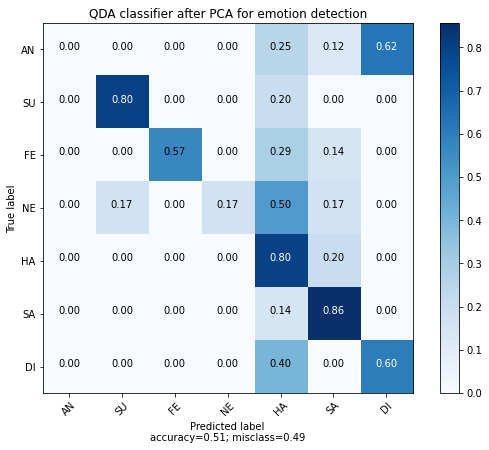

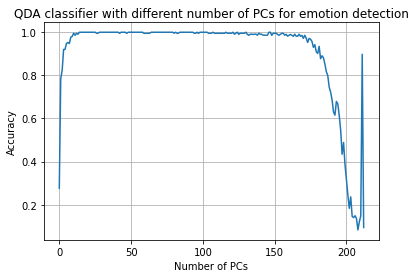

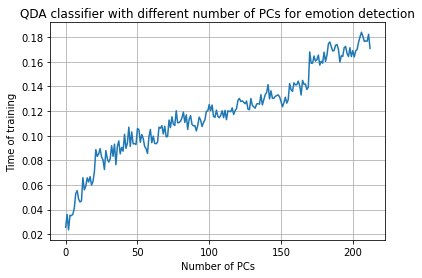

In [ ]:
all_accs_qda, all_times_qda, conf_mat_qda, _, _ = clf_kfold_pca(dataset_emo, int_label_emo, QDA())
plot_confusion_matrix(conf_mat_qda, label_to_int_dict_emo.keys(), 'QDA classifier after PCA for emotion detection')
plt.plot(all_accs_lda)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('QDA classifier with different number of PCs for emotion detection')
plt.savefig('qda_classifications_accuracy_emo.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_qda)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('QDA classifier with different number of PCs for emotion detection')
plt.savefig('qda_pca_classifications_time_emo.pdf', bbox_inches='tight')
plt.show()

### QDA without PCA facial recognition 

In [ ]:
avg_acc, time_elapsed = clf_kfold(dataset_rec, int_label_rec, LDA())
print('Training time:', time_elapsed)

Average Accuracy: 1.0
Training time: 69.39815378189087


### QDA with PCA facial recognition

Average Accuracy for 1 PCs: 0.3440909090909091
Average Accuracy for 2 PCs: 0.8136363636363638
Average Accuracy for 3 PCs: 0.8454545454545455
Average Accuracy for 4 PCs: 0.9618181818181817
Average Accuracy for 5 PCs: 0.9636363636363636
Average Accuracy for 6 PCs: 0.9863636363636363
Average Accuracy for 7 PCs: 0.9809090909090908
Average Accuracy for 8 PCs: 0.9809090909090908
Average Accuracy for 9 PCs: 0.990909090909091
Average Accuracy for 10 PCs: 0.9904545454545455
Average Accuracy for 11 PCs: 0.9954545454545455
Average Accuracy for 12 PCs: 0.9949999999999999
Average Accuracy for 13 PCs: 0.9818181818181818
Average Accuracy for 14 PCs: 0.9863636363636363
Average Accuracy for 15 PCs: 0.959090909090909
Average Accuracy for 16 PCs: 0.9195454545454546
Average Accuracy for 17 PCs: 0.8263636363636362
Average Accuracy for 18 PCs: 0.6468181818181817
Average Accuracy for 19 PCs: 0.4318181818181818
Average Accuracy for 20 PCs: 0.1531818181818182
Average Accuracy for 21 PCs: 0.03318181818181818
Av

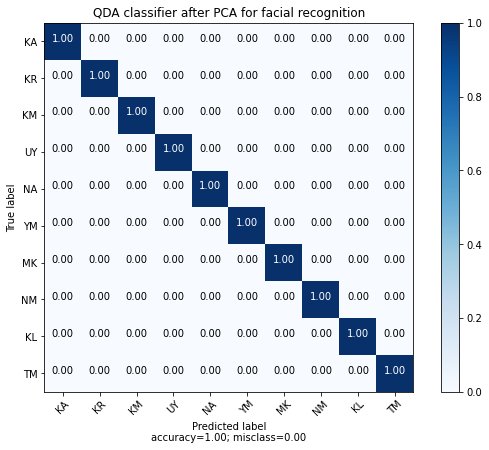

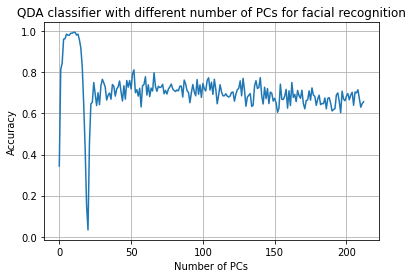

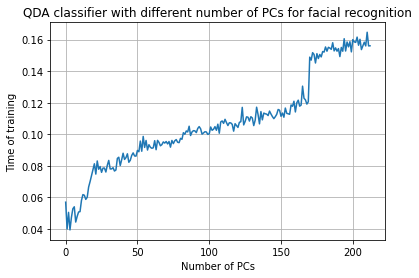

In [ ]:
all_accs_qda, all_times_qda, conf_mat_qda, y_test_rec, y_pred_rec = clf_kfold_pca(dataset_rec, int_label_rec, QDA())
plot_confusion_matrix(conf_mat_qda, label_to_int_dict_rec.keys(), 'QDA classifier after PCA for facial recognition')
plt.plot(all_accs_qda)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('QDA classifier with different number of PCs for facial recognition')
plt.savefig('qda_pca_classifications_accuracy_rec.pdf', bbox_inches='tight')
plt.show()
plt.plot(all_times_qda)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Time of training')
plt.title('QDA classifier with different number of PCs for facial recognition')
plt.savefig('qda_pca_classifications_time_rec.pdf', bbox_inches='tight')
plt.show()

### Plotting some of the PCA-SVM of the classification results

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
def plot_gallery(images, titles, name, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        plt.savefig(name, bbox_inches='tight')

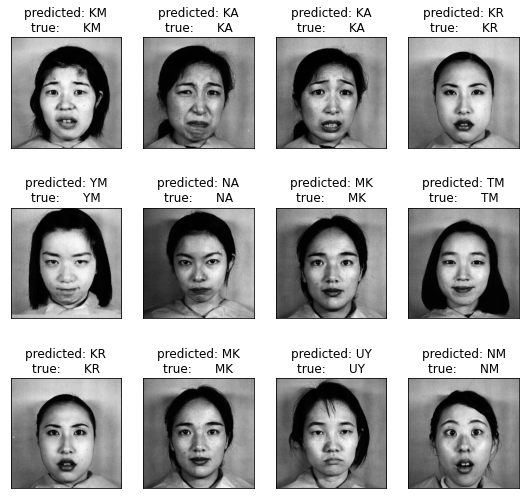

In [ ]:
prediction_titles = [title(y_pred_rec, y_test_rec, int_to_label_dict_rec, i) for i in range(y_pred_rec.shape[0])]
plot_gallery(X_test_rec, prediction_titles,'pred_faces_rec', 256, 256)

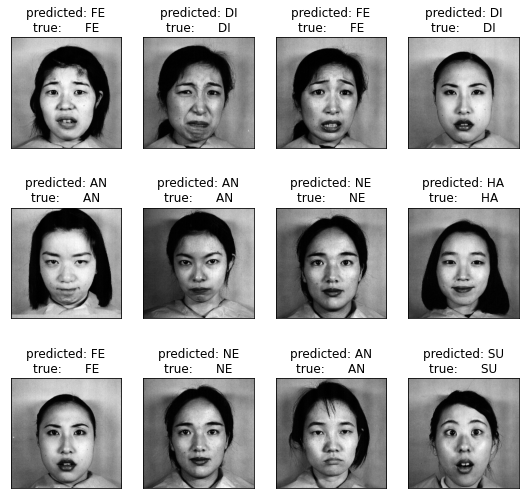

In [ ]:
prediction_titles = [title(y_pred_emo, y_test_emo, int_to_label_dict_emo, i) for i in range(y_pred_emo.shape[0])]
plot_gallery(X_test_emo, prediction_titles,'pred_faces_emo', 256, 256)

# Comparing ML and human performance on emotion recognition

## Loading the Rating data and extracting each emotion human performance

In [ ]:

ratings = pd.read_csv('/content/drive/MyDrive/MML/ratings_60.txt', delimiter=' ', names = ['id', 'HAP', 'SAD', 'SUR', 'ANG', 'DIS', 'FEA', 'sample'])
print(ratings.head())
tmp = list(ratings['sample'])
tmp = [tmp[i][3:5] for i in range(len(tmp))]
ratings['emotion'] = tmp
hap = ratings[ratings['emotion'] == 'HA']['HAP']
sad = ratings[ratings['emotion'] == 'SA']['SAD']
sur = ratings[ratings['emotion'] == 'SU']['SUR']
ang = ratings[ratings['emotion'] == 'AN']['ANG']
dis = ratings[ratings['emotion'] == 'DI']['DIS']
fea = ratings[ratings['emotion'] == 'FE']['FEA']

# hap_norm = stats.boxcox(hap)[0]
# sad_norm = stats.boxcox(sad)[0]
# sur_norm = stats.boxcox(sur)[0]
# ang_norm = stats.boxcox(ang)[0]
# dis_norm = stats.boxcox(dis)[0]
# fea_norm = stats.boxcox(fea)[0]
print()
print('Human performance on recognizing emotions:')
print('Surprise mean:', np.mean(sur))
print('Happiness mean:', np.mean(hap))
print('Disgust mean:', np.mean(dis))
print('Anger mean:', np.mean(ang))
print('Sadness mean:', np.mean(sad))
print('Fear mean:', np.mean(fea))

   id   HAP   SAD   SUR   ANG   DIS   FEA  sample
0   1  2.87  2.52  2.10  1.97  1.97  2.06  KM-NE1
1   2  2.87  2.42  1.58  1.84  1.77  1.77  KM-NE2
2   3  2.50  2.10  1.70  1.50  1.73  1.53  KM-NE3
3   4  4.90  1.13  1.26  1.10  1.03  1.10  KM-HA1
4   5  4.87  1.20  1.43  1.03  1.07  1.07  KM-HA2

Human performance on recognizing emotions:
Surprise mean: 4.643
Happiness mean: 4.4823529411764715
Disgust mean: 4.295483870967742
Anger mean: 4.125333333333333
Sadness mean: 4.0287500000000005
Fear mean: 3.4959375


## Visualizing the rating data

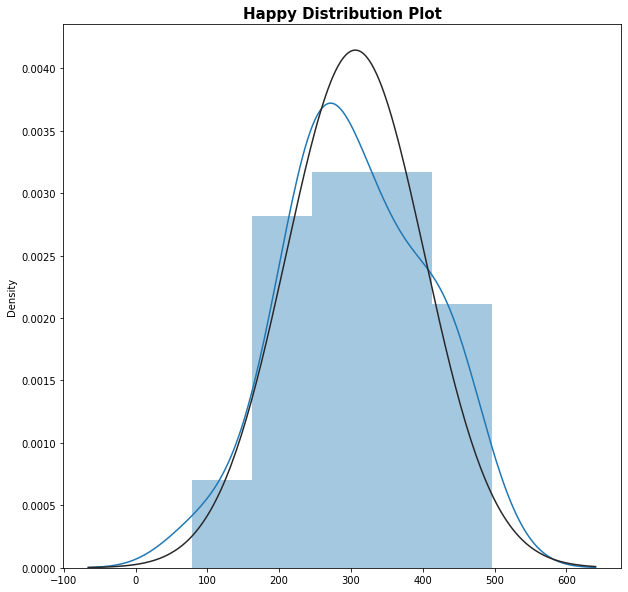

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(emotion, fit=norm)
plt.title("Happy Distribution Plot", size=15, weight='bold')
plt.show()

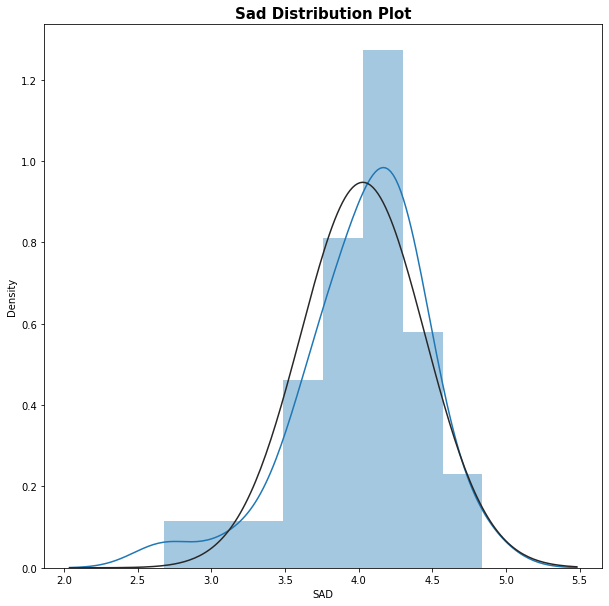

In [ ]:
plt.figure(figsize=(10,10))
emotion = sad
sns.distplot(emotion, fit=norm)
plt.title("Sad Distribution Plot", size=15, weight='bold')
plt.show()

Text(0.5, 1.0, 'The emotion ratings box plot')

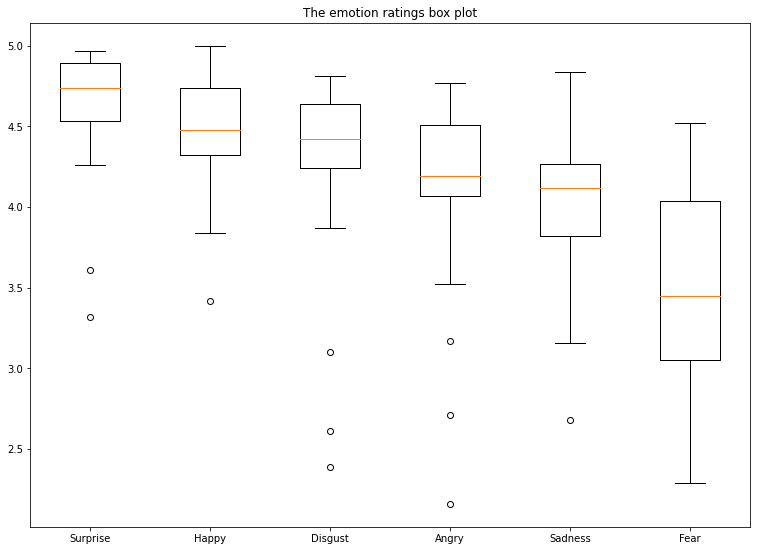

In [ ]:
data = [sur, hap, dis, ang, sad, fea]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, labels=['Surprise', 'Happy', 'Disgust', 'Angry', 'Sadness', 'Fear'])
ax.set_title('The emotion ratings box plot')

## Emotion detection human-machine comparison

In [ ]:
best_pcs = 1+np.argmax(np.array(all_accs))
print(f'Best number of principal components {best_pcs}')
pca = PCA(n_components=best_pcs)
local_dataset = pca.fit_transform(dataset)
kf = KFold(n_splits=k, shuffle=True)
clf = copy.deepcopy(clf_tmp)
# split into a training and testing set
np.random.seed(2045) # The singularity is near!
X_train, X_test, y_train, y_test = train_test_split(local_dataset, labels, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test_emo, y_pred_emo, target_names=label_to_int_dict_emo.keys()))

# 4. Convolutional Neural Network Autoencoder Image Reconstruction and Comparison with PCA

In [ ]:
input_img = keras.Input(shape=(256, 256, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0   

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_data_rec, int_label_rec, test_size=0.2, random_state=0)

x_train = np.array(x_train).astype('float32') / 255.
x_test = np.array(x_test).astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 256, 256, 1))
x_test = np.reshape(x_test, (len(x_test), 256, 256, 1))
# Vectorized labels
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
11/11 [==============================] - 17s 120ms/step - loss: 0.6895 - val_loss: 0.6518
Epoch 2/50
11/11 [==============================] - 0s 29ms/step - loss: 0.6205 - val_loss: 0.5798
Epoch 3/50
11/11 [==============================] - 0s 29ms/step - loss: 0.5752 - val_loss: 0.5635
Epoch 4/50
11/11 [==============================] - 0s 29ms/step - loss: 0.5665 - val_loss: 0.5589
Epoch 5/50
11/11 [==============================] - 0s 29ms/step - loss: 0.5565 - val_loss: 0.5542
Epoch 6/50
11/11 [==============================] - 0s 28ms/step - loss: 0.5589 - val_loss: 0.5520
Epoch 7/50
11/11 [==============================] - 0s 29ms/step - loss: 0.5581 - val_loss: 0.5506
Epoch 8/50
11/11 [==============================] - 0s 28ms/step - loss: 0.5566 - val_loss: 0.5499
Epoch 9/50
11/11 [==============================] - 0s 29ms/step - loss: 0.5580 - val_loss: 0.5489
Epoch 10/50
11/11 [==============================] - 0s 29ms/step - loss: 0.5559 - val_loss: 0.5484
Epoch 1

### Reconstructed images using convolutional autoencoders

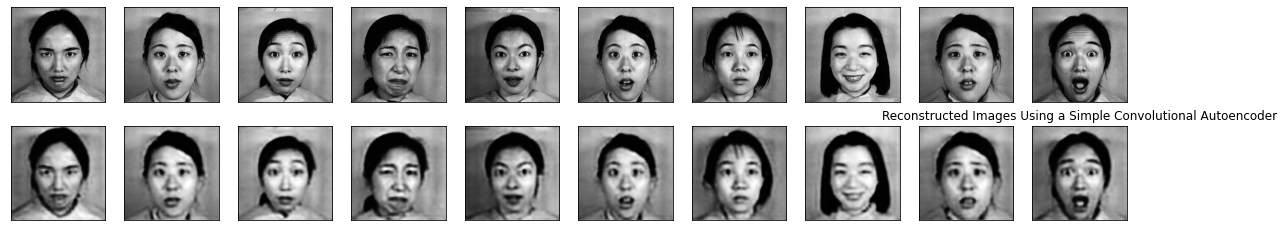

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.title('Reconstructed Images Using a Simple Convolutional Autoencoder')
plt.show()

### Reconstructed images using PCA with 90 percent explained variance

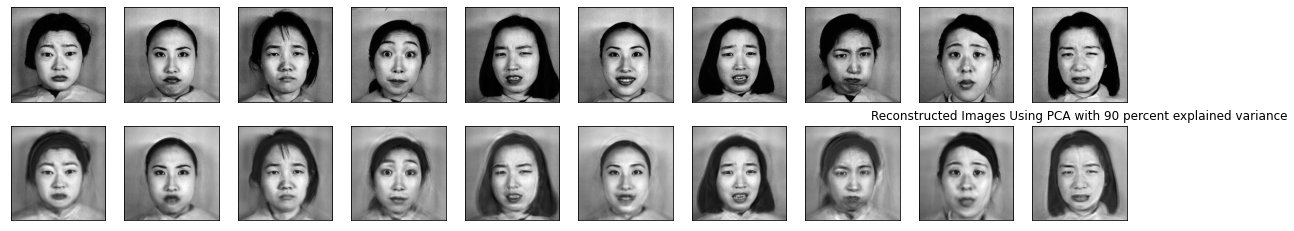

In [ ]:
decoded_imgs = reconstructed90

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    j = np.random.randint(len(decoded_imgs))
    ax = plt.subplot(2, n, i)
    plt.imshow(dataset_rec[j].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[j].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.title('Reconstructed Images Using PCA with 90 percent explained variance')
plt.show()